In [2]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

正在读取日志数据...
发现 11 个监控指标: ['hp_metric', 'lr-Adam', 'train/aeloss_step', 'train/total_loss', 'train/logvar', 'train/kl_loss', 'train/nll_loss', 'train/rec_loss', 'epoch', 'val/rec_loss', 'train/aeloss_epoch']


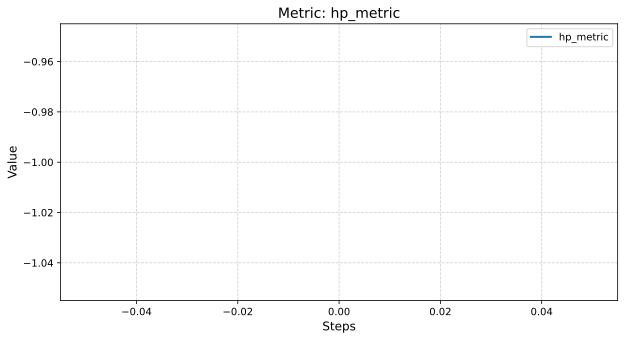

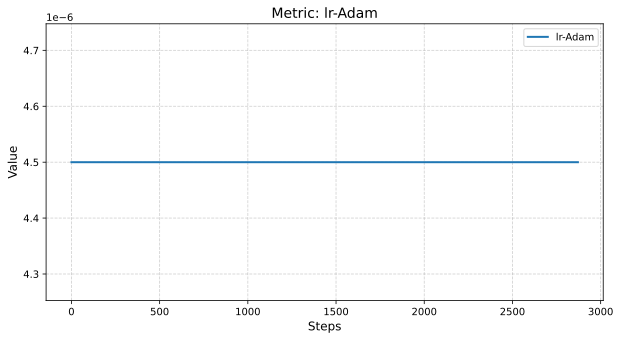

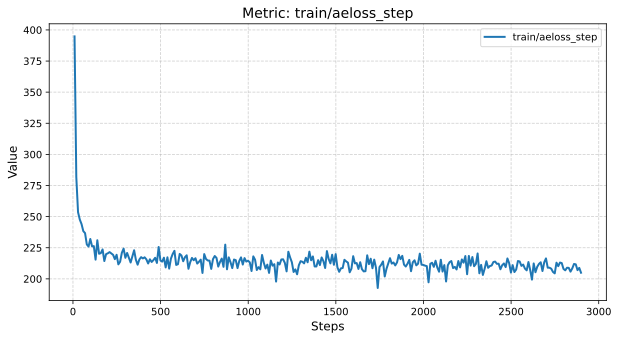

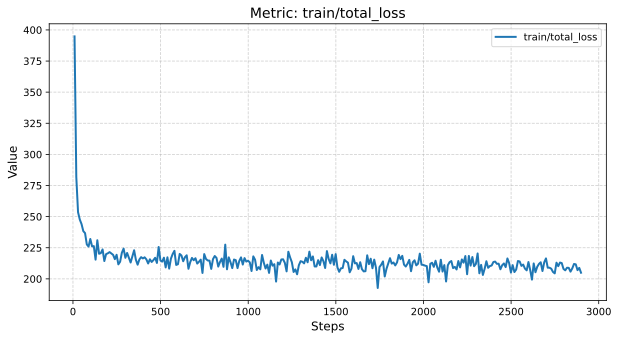

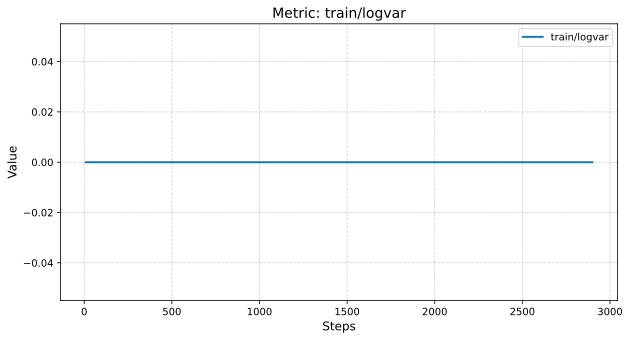

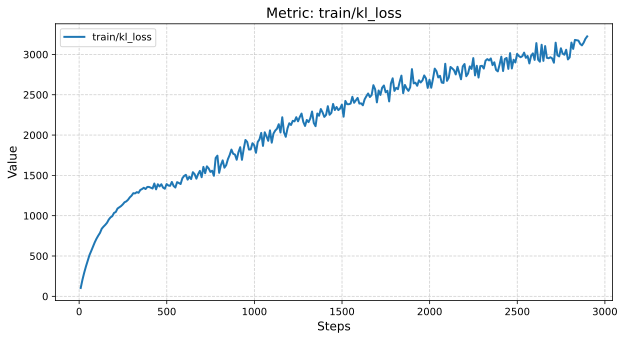

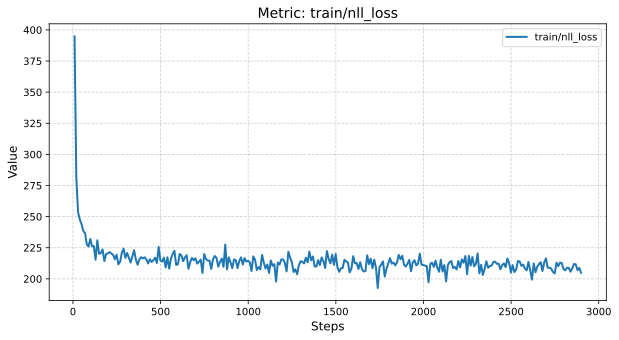

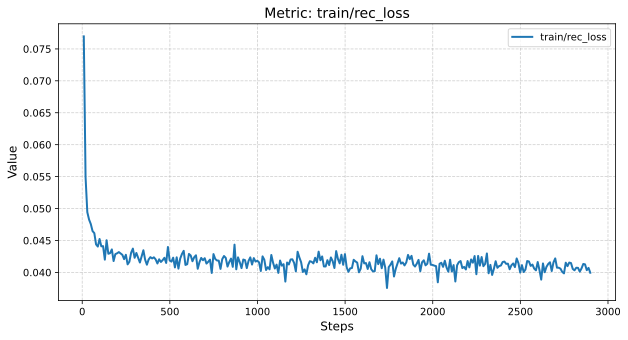

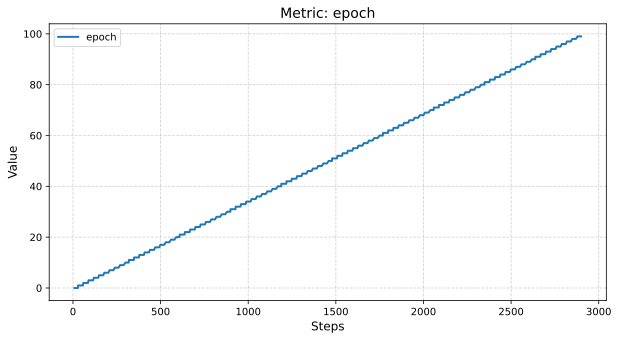

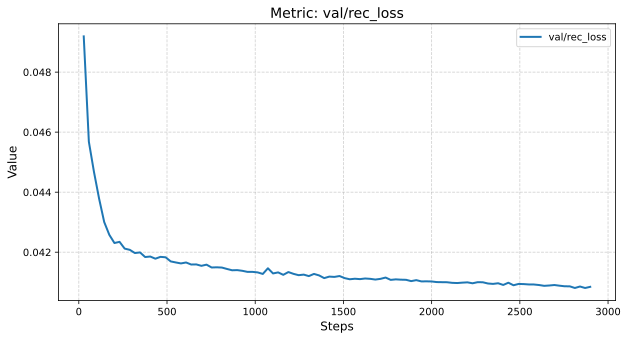

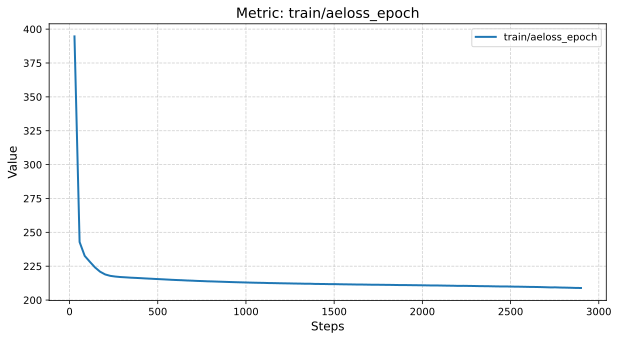

In [4]:
# 确保图片内嵌显示
%matplotlib inline

LOG_PATH = "components/resnet18_TinyImagenet_HC_VAE/lightning_logs/version_0/events.out.tfevents.1763935095.autodl-container-d8774488f4-b8482d06.6912.0"

def plot_tensorboard_log(path):
    # 1. 检查文件是否存在
    if not os.path.exists(path):
        print(f"❌ 错误：找不到文件，请检查路径是否正确：\n{path}")
        return

    print(f"正在读取日志数据...")
    
    # 2. 加载数据
    # size_guidance 用于加载更多数据点，避免被截断
    ea = EventAccumulator(path, size_guidance={ 'scalars': 0 })
    ea.Reload()

    # 3. 获取所有标量标签 (Scalars)
    tags = ea.Tags()['scalars']
    print(f"发现 {len(tags)} 个监控指标: {tags}")

    if len(tags) == 0:
        print("日志中没有发现标量数据 (Scalars)。")
        return

    # 4. 循环绘图
    for tag in tags:
        # 提取数据
        events = ea.Scalars(tag)
        steps = [x.step for x in events]
        values = [x.value for x in events]

        # 绘图
        plt.figure(figsize=(10, 5))
        plt.plot(steps, values, label=tag, linewidth=2)
        
        # 格式化图表
        plt.title(f"Metric: {tag}", fontsize=14)
        plt.xlabel("Steps", fontsize=12)
        plt.ylabel("Value", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend()
        
        # 直接显示
        plt.show()

# --- 运行函数 ---
plot_tensorboard_log(LOG_PATH)